In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU,Conv1D,MaxPooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from sklearn.model_selection import train_test_split
from keras.models import load_model

Using TensorFlow backend.


In [2]:
train = pd.read_csv('./kaggle/train.csv')
test = pd.read_csv('./kaggle/test.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(train, train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]], test_size = 0.10, random_state = 42)

In [4]:
list_sentences_train = X_train["comment_text"]
list_sentences_test = X_test["comment_text"]
#list_sentences_submit = submit["comment_text"]

In [5]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features,char_level=True)

tokenizer.fit_on_texts(list(list_sentences_train))

In [6]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_sentences_test = tokenizer.texts_to_sequences(list_sentences_test)
#list_tokenized_submit = tokenizer.texts_to_sequences(list_sentences_submit)

In [7]:
maxlen = 500
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_sentences_test, maxlen=maxlen)
#X_sub = pad_sequences(list_tokenized_submit, maxlen=maxlen)

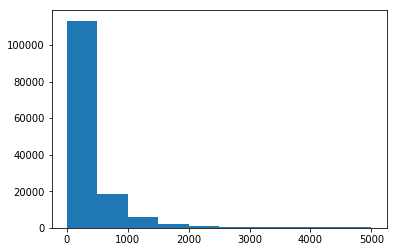

In [8]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords)
plt.show()

In [11]:
def get_model(embed_size,dropout=0.2):
    inp = Input(shape=(maxlen, ))
    x = Embedding(len(tokenizer.word_index)+1, embed_size)(inp)
    x = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu')(x)
    x=MaxPooling1D(pool_size=4)(x)

    x = Bidirectional(GRU(60, return_sequences=True,
                          name='lstm_layer',dropout=dropout,
                          recurrent_dropout=0.2))(x)

    x = GlobalMaxPool1D()(x)

    x = Dense(50, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                   metrics=['accuracy'])
    return model

model = get_model(embed_size = 240, dropout = 0.2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 240)          492480    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 100)          96100     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 125, 100)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 125, 120)          57960     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 120)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                6050      
__________

In [ ]:
batch_size = 32
epochs = 6
#uncomment below to train in your local machine
hist = model.fit(X_t,y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_te,y_test)) #callbacks=callbacks_list)

Train on 143613 samples, validate on 15958 samples
Epoch 1/6
 52160/143613 [=========>....................] - ETA: 18:51 - loss: 0.1016 - acc: 0.9724

In [ ]:
tfjs.converters.save_keras_model(model, "fit-models/")